In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.append('../../pycore/')
from simulate import RBA_result
from utils import extract_details_from_rxnid

import matplotlib.pyplot as plt
import matplotlib.patches as mp
import seaborn as sns
import matplotlib.lines as mlines
%matplotlib inline

#### Load information to back-calculate ribosome rRNA requirements

In [2]:
# Protein lengths and if locating in mitochondria
df_pro = pd.read_excel('../../build_model/input/PROTEIN_stoich_curation_2021-09-28.xlsx')
mito_idx = ['PROSYN-' + df_pro.id[i] for i in df_pro.index \
            if df_pro.subloc_assigned[i] in ['m', 'mm']]

prolens = {'PROSYN-' + df_pro.id[i]:len(df_pro.sequence[i])-1 for i in df_pro.index}
prolens['PROSYN-PROTDUMMY'] = 401

# kribo
kribo = 13.2 * 3600

# MW contribution of protein and rRNA to ribosome
mw_ribonuc_p = 1482.01686; mw_ribonuc_r = 1765.38;
mw_ribomito_p = 2006.93545; mw_ribomito_r = 1640.338253108;

#### Simulation

In [3]:
# Mu = 0
res = RBA_result(biom_id=None)
res.load_from_json('../output/batch/results/mu_0/RBA_result.json')
glc0 = -res.metabolic_flux['EX_glc__D_e']

In [4]:
reslist = []

# Batch
flist = ['vglc_0_5', 'vglc_1_0', 'vglc_2_0', 'vglc_3_0', 'vglc_4_0', 'vglc_5_0',
         'vglc_6_0', 'vglc_7_0', 'vglc_8_0', 'vglc_9_0', 'vglc_10_0', 'vglc_11_0',
         'vglc_11_5', 'vglc_11_6', 'vglc_11_7', 'vglc_12_0', 'vglc_12_1', 'vglc_12_2']
for fdir in flist:
    res = RBA_result(biom_id=None)
    res.load_from_json('../output/batch_mitono_ribono/results_capacitycorrected/' + fdir + '/RBA_result.json')
    reslist.append(res)
    
flist = ['vglc_12_3', 'vglc_12_4', 'vglc_12_5',
         'vglc_13_0', 'vglc_14_0', 'vglc_15_0', 'vglc_16_0', 'vglc_17_0',
         'vglc_20_0', 'vglc_21_0', 'vglc_22_0', 'vglc_23_0', 'vglc_24_0', 'vglc_25_0',
         'vglc_30_0', 'vglc_31_0', 'vglc_32_0', 'vglc_33_0', 'vglc_34_0', 'vglc_35_0']
for fdir in flist:
    res = RBA_result(biom_id=None)
    res.load_from_json('../output/batch_mitono_ribono/results/' + fdir + '/RBA_result.json')
    reslist.append(res)
    
glcs = [glc0] + [-res.metabolic_flux['EX_glc__D_e'] for res in reslist]
etohs = []
for res in reslist:
    if 'EX_etoh_e' in res.metabolic_flux.keys():
        etohs.append(res.metabolic_flux['EX_etoh_e'])
    else:
        etohs.append(0)
grs = [0] + [res.growth_rate for res in reslist]
rcap = [0] + [res.ribo_capacity_usage for res in reslist]
pcap = [0] + [res.proteome_capacity_usage for res in reslist]

In [5]:
pcap_riboadd = [0]; rcap_riboadd = [0];

for res in reslist:
    prosyn_fluxes = dict()
    for k,v in res.raw_flux.items():
        if k.split('-')[0] == 'PROSYN':
            prosyn_fluxes[k] = v

    nuc_rawsum = 0; mito_rawsum = 0;
    for k,v in prosyn_fluxes.items():
        if k in mito_idx:
            mito_rawsum += v * prolens[k]
        else:
            nuc_rawsum += v * prolens[k]

    gr = res.growth_rate
    v_ribonuc = gr / kribo * nuc_rawsum
    v_ribomito = gr / kribo * mito_rawsum
    p_tot = 0.55 * res.raw_flux['BIOSYN-PROTTOBIO']
    r_tot = 0.8 * res.raw_flux['BIOSYN-RNATOBIO']

    pcap_riboadd.append((mw_ribonuc_p * v_ribonuc + mw_ribomito_p * v_ribomito) / p_tot)
    rcap_riboadd.append((mw_ribonuc_r * v_ribonuc + mw_ribomito_r * v_ribomito) / r_tot)

In [6]:
pcap_cor = [pcap[i] + pcap_riboadd[i] for i in range(0,len(pcap))]
rcap_cor = [rcap[i] + rcap_riboadd[i] for i in range(0,len(rcap))]

#### Plot

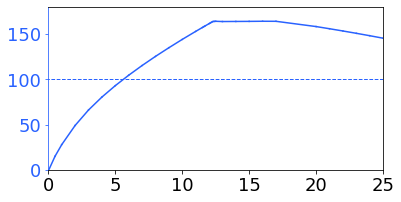

In [7]:
fig,ax = plt.subplots(figsize=(6,3))
color = '#2962ff'

# Plot model-predicted rRNA capacity usage
N = len(glcs)
for i in range(0,N-1):
    p1 = [glcs[i], glcs[i+1]]; p2 = [rcap_cor[i], rcap_cor[i+1]]
    line = mlines.Line2D(p1, p2, color=color, linestyle='-')
    ax.add_line(line);

ax.set_xlim(0,25)
xticks = [0,5,10,15,20,25]
ax.set_xticks(xticks);
ax.set_xticklabels(xticks, fontsize=18);

ax.set_ylim(0,1.8);
yticks = [0, 0.5, 1, 1.5]
yticklabels = [0, 50, 100, 150]
ax.set_yticks(yticks);
ax.set_yticklabels(yticklabels, fontsize=18);

ax.spines['left'].set_color(color)
ax.tick_params(axis='y', colors=color)

#ax.set_xlabel('Glucose uptake rate (mmol gDW$^{-1}$ h$^{-1}$)', fontsize=16);
#ax.set_ylabel('Model-calculated capacity usage (%)', fontsize=16);

# Estimating line
line = mlines.Line2D([-1, 30], [1, 1], color=color, linestyle='--', zorder=0, lw=1)
ax.add_line(line);

"""colors = ['k', '#2962ff']
handles = [mlines.Line2D([], [], color=c, lw=2, ls='-') for c in colors]
legend_labels = ['Protein', 'rRNA']
ax.legend(handles, legend_labels, ncol=1, loc='lower right', fontsize=16);""";

#plt.savefig('../../../scRBA_figures/components/crabtree/capacity_rRNA_usage_mitono_ribono.png', transparent=True, bbox_inches='tight')